<a href="https://colab.research.google.com/github/Apekshagaonkar/dl_covid/blob/main/2_Training_model(NPO).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass Classification with COVID-CXNet



## Importing libraries and run custom functions

In [ ]:
import glob, numpy as np, cv2, matplotlib.pyplot as plt, tensorflow as tf, copy

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import Model, callbacks as cb, optimizers
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Lambda, Input, Conv2D, Conv2DTranspose, concatenate, MaxPooling2D
from tensorflow.keras import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from skimage.filters import rank
from skimage.morphology import disk

In [ ]:
def match_histogram(source, template):
    """
    Adjust the pixel values of a gray-scale image such that its histogram
    matches that of a target image
    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True, return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interpolated_t_values = np.interp(s_quantiles, t_quantiles, t_values)
    hist_matched_img = interpolated_t_values[bin_idx].reshape(oldshape)
    result = np.array(hist_matched_img, dtype='uint8')

    return result
    
def subhist(image_pdf, minimum, maximum, normalize):
    """
    Compute the subhistogram between [minimum, maximum] of a given histogram image_pdf
    :param image_pdf: numpy.array
    :param minimum: int
    :param maximum: int
    :param normalize: boolean
    :return: numpy.array
    """
    hi = np.zeros(shape=image_pdf.shape)
    total = 0
    for idx in range(minimum, maximum+1):
        total += image_pdf[idx]
        hi[idx] = image_pdf[idx]
    if normalize:
        for idx in range(minimum, maximum+1):
            hi[idx] /= total
    return hi


def CDF(hist):
    """
    Compute the CDF of the input histogram
    :param hist: numpy.array()
    :return: numpy.array()
    """
    cdf = np.zeros(shape=hist.shape)
    cdf[0] = hist[0]
    for idx in range(1, len(hist)):
        cdf[idx] = cdf[idx - 1] + hist[idx]
    return cdf


def BEASF(image, gamma):
    """
    Compute the Bi-Histogram Equalization with Adaptive Sigmoid Functions algorithm (BEASF)
    A python implementation of the original MATLAB code:
    https://mathworks.com/matlabcentral/fileexchange/47517-beasf-image-enhancer-for-gray-scale-images
    The algorithm is introduced by E. F. Arriaga-Garcia et al., in the research paper:
    https://ieeexplore.ieee.org/document/6808563
    :param image: numpy.ndarray
    :param gamma: float [0, 1]
    :return: numpy.ndarray
    """
    m = int(np.mean(image, dtype=np.int32))
    h = np.histogram(image, bins=256)[0] / (image.shape[0] * image.shape[1])
    h_lower = subhist(image_pdf=h, minimum=0, maximum=m, normalize=True)
    h_upper = subhist(image_pdf=h, minimum=m, maximum=255, normalize=True)

    cdf_lower = CDF(hist=h_lower)
    cdf_upper = CDF(hist=h_upper)

    # Find x | CDF(x) = 0.5
    half_low = 0
    for idx in range(0, m+2):
        if cdf_lower[idx] > 0.5:
            half_low = idx
            break
    half_up = 0
    for idx in range(m, 256):
        if cdf_upper[idx + 1] > 0.5:
            half_up = idx
            break

    # sigmoid CDF creation
    tones_low = np.arange(0, m+1, 1)
    x_low = 5.0 * (tones_low - half_low) / m  # shift & scale intensity x to place sigmoid [-2.5, 2.5]
    s_low = 1 / (1 + np.exp(-gamma * x_low))  # lower sigmoid

    tones_up = np.arange(m, 256, 1)
    x_up = 5.0 * (tones_up - half_up) / (255 - m)  # shift & scale intensity x to place sigmoid [-2.5, 2.5]
    s_up = 1 / (1 + np.exp(-gamma * x_up))  # upper sigmoid

    mapping_vector = np.zeros(shape=(256,))
    for idx in range(0, m+1):
        mapping_vector[idx] = np.int32(m * s_low[idx])

    minimum = mapping_vector[0]
    maximum = mapping_vector[m]
    for idx in range(0, m+1):
        mapping_vector[idx] = np.int32((m / (maximum - minimum)) * (mapping_vector[idx] - minimum))
    for idx in range(m+1, 256):
        mapping_vector[idx] = np.int32(m + (255 - m) * s_up[idx - m - 1])

    minimum = mapping_vector[m + 1]
    maximum = mapping_vector[255]
    for idx in range(m+1, 256):
        mapping_vector[idx] = (255 - m) * (mapping_vector[idx] - minimum) / (maximum - minimum) + m

    res = copy.deepcopy(image)
    res[:, :] = mapping_vector[image[:, :]]
    return res

## Dataset preparation

In [ ]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/Covid19AI"

/content/drive/My Drive/Covid19AI


num Other images: 501
num Normal images: 501
num Pneumonia  samples: 501
number of total dataset images: 1503
number of total dataset labels: 1503
dataset shape: (1503, 320, 320, 3)


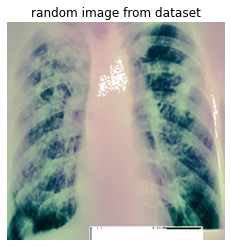

In [ ]:
# run with previously segmented images (ignore 5 last code blocks above)
X = np.load(file='/content/drive/My Drive/Covid19AI/covid_cxr_dataset/train_cxr_segmented.npy')
y = np.load(file='/content/drive/My Drive/Covid19AI/covid_cxr_dataset/train_cxr_ylabel.npy')
#X = np.concatenate((X[:695], X[695:4295], X[6000:9600]), axis=0)
#y = np.concatenate((y[:695], y[695:4295], y[6000:9600]))
# X = np.concatenate((X[:500], X[1000:1500], X[5500:6000]), axis=0)
# y = np.concatenate((y[:500], y[1000:1500], y[5500:6000]))

# one-hot encoding of labels
transformer = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])])
y_reshaped = y.reshape(-1, 1)
y_column_encoded = transformer.fit_transform(y_reshaped)

# compute num images in each class
num_pnem_samples = 0
num_other_samples = 0
num_normal_samples = 0
for idx, img in enumerate(X):
    if y[idx] == 1:
        num_pnem_samples += 1
    elif y[idx] == 0:
        num_normal_samples += 1
    else:
        #print(y[idx])
        num_other_samples += 1
print('num Other images:', num_other_samples)
print('num Normal images:', num_normal_samples)
print('num Pneumonia  samples:', num_pnem_samples)

# manual label smoothing by 0.1 deviation
# y[np.where(y == 0)] = 0.1
# y[np.where(y == 1)] = 0.9

# perform histogram matching since majority of the images are from NIH-14 dataset
base_image = X[0]
X = np.array([match_histogram(source=image, template=base_image) for image in X])

# apply image enhancements and concat with the original image
X_beasf = np.array([ for image in X])
X_clahe = np.array([cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(image) for image in X])
X_clahe = np.array([np.expand_dims(a=image, axis=-1) for image in X_clahe])
X = np.concatenate((X_beasf, X_clahe, X), axis=-1)

# rescale images from [0, 255] to [0, 1]
# X = np.array([X[idx] / 255. for idx in range(len(X))])

print('number of total dataset images:', len(X))
print('number of total dataset labels:', len(y))
print('dataset shape:', X.shape)

rnd_idx = np.random.choice(a=len(X), size=None)
plt.imshow(X=X[rnd_idx].squeeze(), cmap='gray')
plt.axis('off')
plt.title(label='random image from dataset')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y_column_encoded, test_size=0.2, 
                                                    random_state=18)

# NOTE: sklearn train_test_split function copies the dataset, hence deleting initial data
# variables will increase RAM space drastically (~ x2)
del X, X_beasf, X_clahe

In [ ]:
del base_image, y_reshaped, transformer, rnd_idx, y_column_encoded
del num_other_samples, num_pnem_samples, num_normal_samples

## Retraining/ fine-tuning CheXNet model

In [ ]:
# IMPORTANT: applying zoom and brightness at the same time will change image pixel range from
# [0, 1] to [0, 255], hence we need to add rescaling again (despite doing it when importing
# dataset). Otherwise, model will see all validation data (not undergone augmentation) as 
# black images giving a same prediction value for all
augmenter = ImageDataGenerator(rotation_range=60, horizontal_flip=False, vertical_flip=False, 
                               zoom_range=[0.8, 1.5], brightness_range=[0.5, 1.3], rescale=1./255,
                               width_shift_range=0.1, height_shift_range=0.1, fill_mode='constant')

# NOTE: Keras ImageDataGenerator does not keep input image default ratio (as of v2.3.1)
# NOTE: Keras ImageDataGenerator does not resize-and-padd when doing rotation (thus 
# loosing part of the image due to cropping while rotating)
checkpoint = cb.ModelCheckpoint('/content/drive/My Drive/Covid19AI/covid_model/eps={epoch:03d}_valLoss={val_loss:.4f}.hdf5',
                                monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cb_list = [checkpoint]

max px value of input image: 255
max px value of augmented image: 1.0


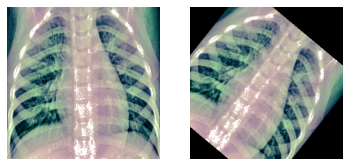

In [ ]:
# check image augmenter to see if it is working correctly and rescaling to [0, 1]
idx = np.random.randint(low=0, high=len(X_train), size=None)
print('max px value of input image:', np.max(X_train[idx]))

augmented = augmenter.flow(X_train[idx:idx+1], batch_size=1).next()
print('max px value of augmented image:', np.max(augmented))
plt.subplot(1, 2, 1)
plt.imshow(X_train[idx])
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(augmented.squeeze())
plt.axis('off')
plt.show()

In [ ]:
# del X_train
X_test = np.array([X_test[idx] / 255. for idx in range(len(X_test))])

In [ ]:
backbone = load_model("/content/drive/My Drive/Covid19AI/Pretrained_Model/CheXNet_model.hdf5")
fc = Dense(units=10, activation='relu', name='fc')(backbone.layers[-2].output)
do = Dropout(rate=0.2, name='dropout')(fc)
output = Dense(units=3, activation='softmax', name='pred')(do)
classifier = Model(inputs=backbone.input, outputs=output)
classifier.trainable = True

fast_adam = optimizers.Adam(learning_rate=0.0001)
smoothened_cce = tf.losses.CategoricalCrossentropy(label_smoothing=0.1)
classifier.compile(optimizer=fast_adam, loss=smoothened_cce, metrics=['accuracy'])
# classifier.summary()
print('num pretrained network layers:', len(classifier.layers))
del backbone

num pretrained network layers: 431


In [ ]:
!pip3 install keras_lr_finder

In [ ]:
from keras_lr_finder.lr_finder import LRFinder
lr_finder = LRFinder(model=classifier)
lr_finder.find(x_train=X_train, y_train=y_train, start_lr=0.00001,end_lr=0.1, batch_size=20, epochs=4)
# best lr is where the plot has highest decreasing slope before the loss jump
#lr_finder.plot_loss()
#lr_finder.plot_loss_change(sma=5, n_skip_beginning=5, n_skip_end=5, y_lim=(-0.05, 0.05))

Epoch 1/4
61/61 [==============================] - 76s 475ms/step - loss: 1.0969 - accuracy: 0.3760
Epoch 2/4
61/61 [==============================] - 25s 410ms/step - loss: 0.9277 - accuracy: 0.6439
Epoch 3/4
61/61 [==============================] - 25s 416ms/step - loss: 0.6320 - accuracy: 0.8211
Epoch 4/4
61/61 [==============================] - 26s 421ms/step - loss: 0.8080 - accuracy: 0.7005


class weights are: [1. 1. 1.]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20
75/75 [==============================] - 52s 541ms/step - loss: 1.0881 - accuracy: 0.4047 - val_loss: 1.0594 - val_accuracy: 0.4020

Epoch 00001: val_loss improved from inf to 1.05936, saving model to /content/drive/My Drive/Covid19AI/covid_model/eps=001_valLoss=1.0594.hdf5
Epoch 2/20
75/75 [==============================] - 35s 462ms/step - loss: 0.9996 - accuracy: 0.6054 - val_loss: 0.9750 - val_accuracy: 0.6977

Epoch 00002: val_loss improved from 1.05936 to 0.97496, saving model to /content/drive/My Drive/Covid19AI/covid_model/eps=002_valLoss=0.9750.hdf5
Epoch 3/20
75/75 [==============================] - 35s 458ms/step - loss: 0.9378 - accuracy: 0.6518 - val_loss: 0.8559 - val_accuracy: 0.8538

Epoch 00003: val_loss improved from 0.97496 to 0.85591, saving model to /content/drive/My Drive/Covid19AI/covid_

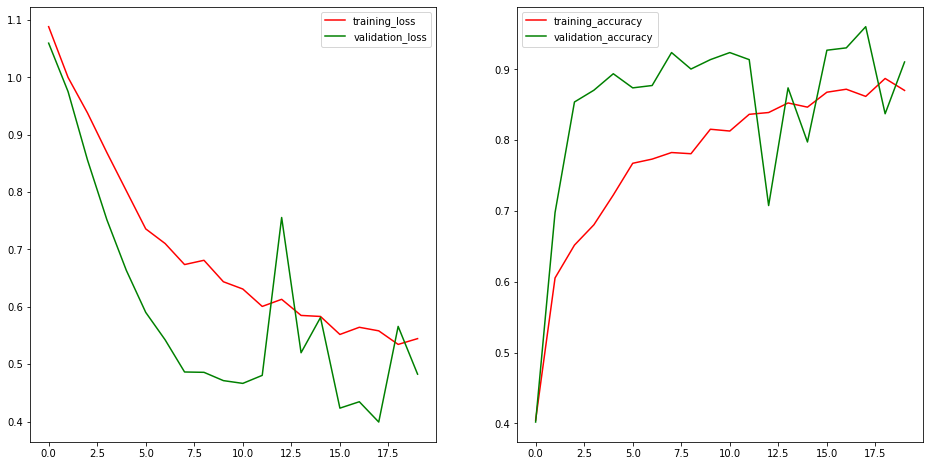

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(y), y=y).astype('float32')
print('class weights are:', class_weights)
fine_tuning = classifier.fit(augmenter.flow(x=X_train, y=y_train, batch_size=16), 
                             steps_per_epoch=len(X_train)//16,
                             callbacks=cb_list, epochs=20, verbose=1, 
                             validation_data=(X_test, y_test),
                             class_weight=dict({0: class_weights[0], 1: class_weights[1], 
                                                2: class_weights[2]}))

fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(fine_tuning.history['loss'], color='r', label='training_loss')
plt.plot(fine_tuning.history['val_loss'], color='g', label='validation_loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(fine_tuning.history['accuracy'], color='r', label='training_accuracy')
plt.plot(fine_tuning.history['val_accuracy'], color='g', label='validation_accuracy')
plt.legend()
plt.show()
# fig.savefig('/content/drive/My Drive/covid_model/fine_tuning.png')

In [ ]:
classifier.load_weights('/content/drive/My Drive/Covid19AI/covid_model/eps=018_valLoss=0.3992.hdf5')
print('number of test-set images:', len(y_test))

y_pred = classifier.predict(X_test)
y_pred = np.array([np.argmax(pred) for pred in y_pred])
print('predicted labels: \n', y_pred)

y_test_decoded = np.array([np.argmax(label) for label in y_test])
print('true labels: \n', y_test_decoded)

# y_pred = np.round(np.reshape(a=y_pred, newshape=(1, -1)), decimals=2)[0]
# print(y_pred)
# y_pred_rnd = np.round(np.reshape(a=y_pred, newshape=(1, -1)))[0]
cm = confusion_matrix(y_true=y_test_decoded, y_pred=y_pred)
print('confusion matrix:')
print(cm)
print('test-set accuracy:', (cm[0][0] + cm[1][1] + cm[2][2])/np.sum(cm))

number of test-set images: 301
predicted labels: 
 [0 2 0 1 2 0 2 2 0 0 2 1 1 1 2 0 2 2 0 1 0 1 2 0 2 2 0 2 1 0 1 0 2 2 0 1 0
 0 0 1 0 2 0 1 2 1 0 0 1 0 0 2 2 2 1 0 0 0 1 2 0 0 2 1 1 2 1 2 0 1 2 2 1 0
 0 2 0 1 0 1 2 1 2 0 1 1 2 2 2 1 0 2 2 1 1 1 1 0 2 0 1 0 0 0 0 2 1 2 0 0 1
 0 0 0 2 1 2 2 1 0 2 0 2 0 1 1 1 0 0 0 2 0 2 1 1 2 0 0 0 1 2 1 2 2 0 2 0 2
 2 1 2 1 2 1 2 1 0 1 1 2 1 1 0 0 0 0 2 2 2 0 1 0 1 2 0 1 0 2 2 0 2 0 0 0 0
 2 1 2 0 0 0 1 1 1 1 1 2 2 0 1 0 2 2 2 2 1 1 0 2 1 2 0 1 0 0 2 0 0 1 0 2 1
 0 0 0 2 2 1 2 2 0 2 0 1 1 1 0 1 2 0 0 1 1 0 0 0 1 1 1 2 0 2 2 0 2 0 0 2 2
 2 0 2 0 0 1 1 0 1 0 1 2 1 2 2 1 1 0 1 2 1 2 2 0 2 0 2 0 1 2 0 0 2 1 1 0 0
 2 0 1 2 2]
true labels: 
 [0 1 0 1 2 0 1 2 0 0 2 1 1 1 2 0 2 2 0 1 0 2 2 0 2 2 0 2 1 0 1 0 2 2 0 1 0
 0 0 1 0 2 0 1 2 1 0 0 1 0 0 2 2 2 1 0 0 0 1 2 0 0 2 1 1 2 1 2 0 1 2 2 1 0
 0 2 0 1 0 1 2 1 2 0 1 1 2 2 2 1 0 2 2 1 1 1 1 0 2 0 1 0 1 0 0 2 1 2 0 0 1
 0 0 0 2 1 2 2 1 0 2 0 2 0 1 1 1 0 0 0 2 0 2 1 1 2 0 0 0 1 2 1 2 2 0 2 0 2
 2 1 1 1 2 1 2 1 0 1 1

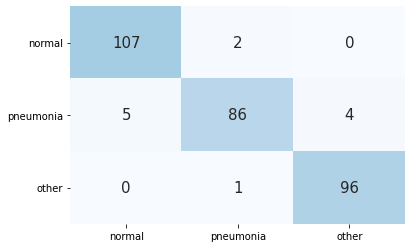

In [ ]:
import seaborn as sns
fig1 = plt.figure()
labels = ['normal', 'pneumonia', 'other']
h = sns.heatmap(data=cm, cmap='Blues', annot=True, annot_kws={'size': 15}, fmt='d',
                vmin=0, vmax=300, xticklabels=labels, yticklabels=labels, cbar=False)
h.set_yticklabels(h.get_yticklabels(), rotation=0)
# plt.title('annotated heatmap for confusion matrix')
plt.show()
fig1.savefig('/content/drive/My Drive/multiclass_cm_heatmap.pdf')

## Heatmap generation for sample image

In [ ]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8, normalize=True):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(inputs=[self.model.input], outputs=[self.model.get_layer(self.layerName).output,
                                                              self.model.output])
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            inputs = np.expand_dims(inputs, axis=0)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        # if gradients are too small (GradCAM is zero everywhere)
        # equal to changing the value of 'eps' func arg
        grads = grads / (grads.numpy().max() - grads.numpy().min())
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        h, w = image.shape[:2]
        heatmap = cv2.resize(cam.numpy(), (w, h))
        print('avg heatmap value:', np.mean(heatmap))
        print('max heatmap value:', np.max(heatmap))
        # ignore certain values lower than a threshold to get sharper heatmaps
        # heatmap[np.where(heatmap < 1)] = 0
        if normalize:
            # normalize the heatmap such that all values lie in the range
            # [0, 1], scale the resulting values to the range [0, 255],
            # and then convert to an unsigned 8-bit integer
            numer = heatmap - np.min(heatmap)
            denom = (heatmap.max() - heatmap.min()) + eps
            heatmap = numer / denom
            heatmap = (heatmap * 255)
        return heatmap.astype("uint8")

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        # if the input image is grey-scale, convert it to 3-dim
        if len(image.shape) == 2 or image.shape[-1] != 3:
            image = cv2.cvtColor(src=image, code=cv2.COLOR_GRAY2RGB)
        # if image px values are in [0, 1], upscale to [0, 255]
        if np.max(image) <= 1.0:
            image = image * 255.0
        output = cv2.addWeighted(image.astype('uint8'), alpha, heatmap, 1 - alpha, 0)
        return output

image index: 3
avg heatmap value: 10.129687
max heatmap value: 31.116272


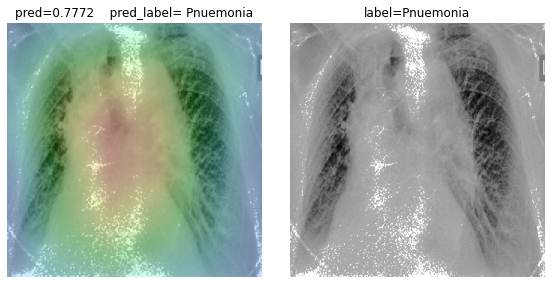

In [ ]:
predictor = load_model('/content/drive/My Drive/Covid19AI/covid_model/eps=018_valLoss=0.3992.hdf5')
#predictor = classifier
# IMG_ID = np.random.randint(low=0, high=len(X_test), size=None)
IMG_ID = 3
print('image index:', IMG_ID)


test_img = np.zeros(shape=(600, 600, 3))
test_img[140:460, 140:460] = X_test[IMG_ID]
test_img = cv2.resize(src=test_img, dsize=(320, 320))


# test_img = X_test[IMG_ID]
plain_img = test_img[:, :, 2]
temp_img = (plain_img * 255.).astype('uint8')

labels = ['Normal', 'Pnuemonia', 'Others']
pred = predictor.predict(np.expand_dims(test_img, axis=0))
pred_label = labels[np.argmax(pred)]


cam = GradCAM(model=predictor, classIdx=np.argmax(pred), layerName=None)
heatmap = cam.compute_heatmap(image=test_img, normalize=True)
overlaid_heatmap = cam.overlay_heatmap(heatmap=heatmap, image=temp_img, alpha=0.8, 
                                       colormap=cv2.COLORMAP_HSV)

overlaid_heatmap = overlaid_heatmap[75:245, 75:245, :]
# test_img = test_img[75:245, 75:245]

fig = plt.figure(num=2, figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(overlaid_heatmap)
plt.axis('off')
plt.title('pred=%.4f    pred_label= %s' % (np.max(pred), pred_label))

plt.subplot(1, 2, 2)
plt.imshow(X_test[IMG_ID][:, :, 2], cmap='gray')
plt.axis('off')
plt.title('label=%s' % labels[y_test_decoded[IMG_ID]])
fig.tight_layout()
plt.show()
# fig.savefig('/content/drive/My Drive/multi_%d.pdf' % IMG_ID, bbox_inches='tight', pad_inches=0.1)

## Storing weights

In [ ]:
from keras import backend as K
import tensorflow as tf

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
   
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph

In [ ]:
frozen_graph = freeze_session(K.get_session(), output_names=[out.op.name for out in classifier.outputs])

In [ ]:
tf.train.write_graph(frozen_graph, os.getcwd(), 'normal_pneumonia_other.pb', as_text=False)